In [1]:
#Results

In [3]:
# !pip install tensorflow xgboost joblib pandas numpy matplotlib seaborn

import os
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns



✅ All models and scalers loaded successfully.


In [13]:
BASE_DIR = '/content'  # or your Drive path

# Correct model paths
flood_model_path   = os.path.join(BASE_DIR, 'pluvial_flood_model_multiclass.joblib')
fire_model_path    = os.path.join(BASE_DIR, 'fire_cnn_lstm_final.h5')
landslide_model_path = os.path.join(BASE_DIR, 'landslide_xgb_final.joblib')

# ✅ Correctly load each type
flood_model   = joblib.load(flood_model_path)              # XGBoost / RandomForest
fire_model    = tf.keras.models.load_model(fire_model_path)  # CNN-LSTM (Keras)
landslide_xgb = joblib.load(landslide_model_path)            # XGBoost

# ✅ Load scalers
flood_scaler  = joblib.load(os.path.join(BASE_DIR, 'pluvial_flood_scaler.joblib'))
fire_scaler   = joblib.load(os.path.join(BASE_DIR, 'fire_scaler.joblib'))
land_scaler   = joblib.load(os.path.join(BASE_DIR, 'land_scaler.joblib'))

print("✅ All models and scalers loaded successfully!")

✅ All models and scalers loaded successfully!


In [14]:
print("Flood scaler features:\n", flood_scaler.feature_names_in_)
print("\nFire scaler features:\n", fire_scaler.feature_names_in_)
print("\nLandslide scaler features:\n", land_scaler.feature_names_in_)


Flood scaler features:
 ['X' 'Y' 'Slope' 'Curvature' 'Aspect' 'TWI' 'FA' 'Drainage' 'Rainfall']

Fire scaler features:
 ['X' 'Y' 'month' 'day' 'FFMC' 'DMC' 'DC' 'ISI' 'temp' 'RH' 'wind' 'rain']

Landslide scaler features:
 ['ID' 'LONG' 'LAT' 'Elevation' 'AAP(mm)' 'RiverDIST(m)' 'FaultDIST(m)'
 'Slop(Percent)' 'Slop(Degrees)' 'Climate_Type' 'DES_ClimateType']


In [19]:
# 🌊 Flood Inputs (Low → High)
# 🌊 Updated Flood Inputs for Pluvial Flood Model (using real physical/geospatial factors)
flood_inputs = {
    "Low": {
        'X': 2.0,
        'Y': 10.0,
        'Slope': 1.0,         # gentle slope → low flood risk
        'Curvature': 0.1,     # low curvature → flat terrain
        'Aspect': 15.0,       # NE facing, less runoff
        'TWI': 3.0,           # low topographic wetness index
        'FA': 20.0,           # small flow accumulation
        'Drainage': 0.2,      # efficient drainage
        'Rainfall': 30.0      # low precipitation
    },
    "Moderate": {
        'X': 15.0,
        'Y': 20.0,
        'Slope': 8.0,         # moderate slope
        'Curvature': 0.5,     # moderate curvature
        'Aspect': 120.0,      # SE facing
        'TWI': 7.0,           # moderate wetness
        'FA': 300.0,          # moderate flow accumulation
        'Drainage': 0.5,      # partially blocked drainage
        'Rainfall': 160.0     # moderate rainfall
    },
    "High": {
        'X': 25.0,
        'Y': 30.0,
        'Slope': 15.0,        # steep slopes
        'Curvature': 1.2,     # high curvature → concave/convex flow zones
        'Aspect': 220.0,      # SW facing → higher exposure
        'TWI': 12.0,          # high wetness accumulation
        'FA': 1200.0,         # large flow accumulation area
        'Drainage': 0.9,      # poor drainage / blocked
        'Rainfall': 300.0     # intense rainfall
    }
}


# ⛰️ Landslide Inputs (Low → High)
landslide_inputs = {
    "Low": {
        'ID': 1, 'LONG': 78.0, 'LAT': 31.0, 'Elevation': 200, 'AAP(mm)': 120,
        'RiverDIST(m)': 1000, 'FaultDIST(m)': 1500, 'Slop(Percent)': 20, 'Slop(Degrees)': 10,
        'Climate_Type': 1, 'DES_ClimateType': 1
    },
    "Moderate": {
        'ID': 2, 'LONG': 78.4, 'LAT': 31.3, 'Elevation': 400, 'AAP(mm)': 280,
        'RiverDIST(m)': 400, 'FaultDIST(m)': 600, 'Slop(Percent)': 45, 'Slop(Degrees)': 30,
        'Climate_Type': 2, 'DES_ClimateType': 1
    },
    "High": {
        'ID': 3, 'LONG': 78.5, 'LAT': 31.6, 'Elevation': 550, 'AAP(mm)': 500,
        'RiverDIST(m)': 100, 'FaultDIST(m)': 120, 'Slop(Percent)': 78, 'Slop(Degrees)': 55,
        'Climate_Type': 3, 'DES_ClimateType': 2
    }
}

# 🔥 Fire Inputs (Low → High)
fire_inputs = {
    "Low": {
        'X': 5.0, 'Y': 4.0, 'month': 1, 'day': 15, 'FFMC': 75, 'DMC': 30,
        'DC': 120, 'ISI': 3, 'temp': 20, 'RH': 70, 'wind': 5, 'rain': 4.0, 'area': 2
    },
    "Moderate": {
        'X': 5.3, 'Y': 4.3, 'month': 3, 'day': 10, 'FFMC': 85, 'DMC': 90,
        'DC': 450, 'ISI': 6.5, 'temp': 30, 'RH': 40, 'wind': 12, 'rain': 1.0, 'area': 10
    },
    "High": {
        'X': 6.0, 'Y': 4.8, 'month': 5, 'day': 20, 'FFMC': 98, 'DMC': 190,
        'DC': 900, 'ISI': 15, 'temp': 45, 'RH': 14, 'wind': 30, 'rain': 0.0, 'area': 70
    }
}


,Scenario,Flood_Label,Fire_Risk,Landslide_Risk,Overall_Level
0,Low,🟠 High,🟠 Moderate,🟢 Low,🟠 Moderate
1,Moderate,🟠 High,🟠 Moderate,🔴 High,🔴 High
2,High,🟠 High,🔴 High,🔴 High,🔴 High


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


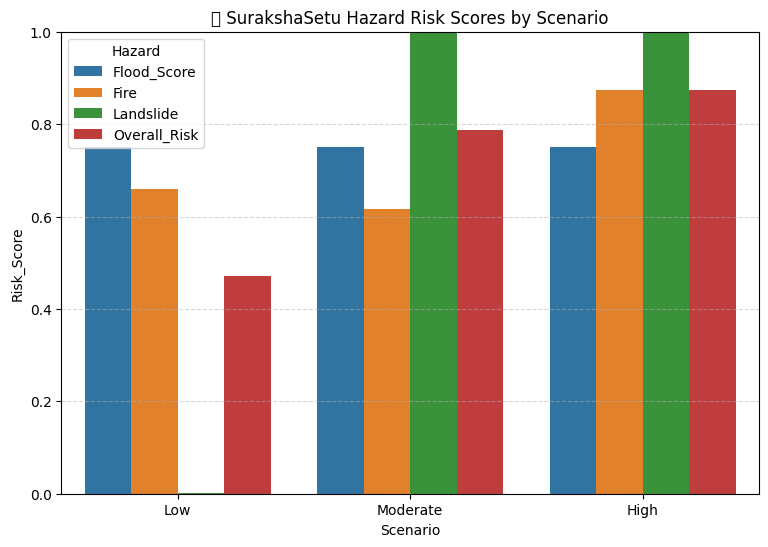


⚙️ Scenario: Low
  🌊 Flood: 🟠 High (Class 3, Score 0.75)
  🔥 Fire: 🟠 Moderate (0.66)
  ⛰️ Landslide: 🟢 Low (0.00)
  🧩 Overall Risk Level: 🟠 Moderate (0.47)

⚙️ Scenario: Moderate
  🌊 Flood: 🟠 High (Class 3, Score 0.75)
  🔥 Fire: 🟠 Moderate (0.62)
  ⛰️ Landslide: 🔴 High (1.00)
  🧩 Overall Risk Level: 🔴 High (0.79)

⚙️ Scenario: High
  🌊 Flood: 🟠 High (Class 3, Score 0.75)
  🔥 Fire: 🔴 High (0.87)
  ⛰️ Landslide: 🔴 High (1.00)
  🧩 Overall Risk Level: 🔴 High (0.87)

✅ Multi-hazard risk inference completed successfully.


In [20]:
# ======================================================
# 🌍 SURAKSHASETU – MULTI-HAZARD RISK INFERENCE (UPDATED)
# ======================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 🧩 Helper functions
# ----------------------------
def risk_label(prob):
    """Convert probability → categorical label."""
    if prob < 0.4:
        return "🟢 Low"
    elif prob < 0.7:
        return "🟠 Moderate"
    else:
        return "🔴 High"

def flood_class_label(cls):
    """Map flood susceptibility class → readable label."""
    mapping = {
        0: "🟢 Very Low",
        1: "🟢 Low",
        2: "🟡 Moderate",
        3: "🟠 High",
        4: "🔴 Very High"
    }
    return mapping.get(int(cls), "Unknown")

def prepare_flood_input(level):
    df = pd.DataFrame([flood_inputs[level]])
    df = df.reindex(columns=flood_scaler.feature_names_in_, fill_value=0)
    X = flood_scaler.transform(df)
    return X  # multi-class model takes single-row vector

def prepare_fire_input(level):
    df = pd.DataFrame([fire_inputs[level]])
    df = df.reindex(columns=fire_scaler.feature_names_in_, fill_value=0)
    X = fire_scaler.transform(df)
    X_seq = np.expand_dims(X, axis=-1)
    return X_seq

def prepare_land_input(level):
    df = pd.DataFrame([landslide_inputs[level]])
    df = df.reindex(columns=land_scaler.feature_names_in_, fill_value=0)
    X = land_scaler.transform(df)
    return X

# ----------------------------
# 🌍 Inference Loop
# ----------------------------
results = []
for level in ["Low", "Moderate", "High"]:
    # --- FLOOD (Multi-class model)
    Xf = prepare_flood_input(level)
    flood_pred_class = int(flood_model.predict(Xf)[0])
    flood_label = flood_class_label(flood_pred_class)

    # Convert flood class (0–4) into a normalized risk value (0–1 scale)
    flood_prob = flood_pred_class / 4.0

    # --- FIRE (CNN-LSTM, probability output)
    Xfi = prepare_fire_input(level)
    fire_prob = float(fire_model.predict(Xfi, verbose=0)[0][0])

    # --- LANDSLIDE (XGBoost, probability output)
    Xl = prepare_land_input(level)
    land_prob = float(landslide_xgb.predict_proba(Xl)[0][1])

    # --- Meta or Combined risk (weighted average)
    meta_prob = np.mean([flood_prob, fire_prob, land_prob])

    results.append({
        "Scenario": level,
        "Flood_Class": flood_pred_class,
        "Flood_Label": flood_label,
        "Flood_Score": flood_prob,
        "Fire": fire_prob,
        "Landslide": land_prob,
        "Overall_Risk": meta_prob,
        "Flood_Risk": flood_label,
        "Fire_Risk": risk_label(fire_prob),
        "Landslide_Risk": risk_label(land_prob),
        "Overall_Level": risk_label(meta_prob)
    })

# Convert to DataFrame for display
df_results = pd.DataFrame(results)
display(df_results[["Scenario","Flood_Label","Fire_Risk","Landslide_Risk","Overall_Level"]])

# ----------------------------
# 📊 Visualization
# ----------------------------
plt.figure(figsize=(9,6))
melt_df = df_results.melt(id_vars=['Scenario'],
                          value_vars=['Flood_Score','Fire','Landslide','Overall_Risk'],
                          var_name='Hazard', value_name='Risk_Score')
sns.barplot(data=melt_df, x='Scenario', y='Risk_Score', hue='Hazard')
plt.title("🌍 SurakshaSetu Hazard Risk Scores by Scenario")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# ----------------------------
# 🧩 Interpretation Output
# ----------------------------
for _, row in df_results.iterrows():
    print(f"\n⚙️ Scenario: {row['Scenario']}")
    print(f"  🌊 Flood: {row['Flood_Risk']} (Class {row['Flood_Class']}, Score {row['Flood_Score']:.2f})")
    print(f"  🔥 Fire: {row['Fire_Risk']} ({row['Fire']:.2f})")
    print(f"  ⛰️ Landslide: {row['Landslide_Risk']} ({row['Landslide']:.2f})")
    print(f"  🧩 Overall Risk Level: {row['Overall_Level']} ({row['Overall_Risk']:.2f})")

print("\n✅ Multi-hazard risk inference completed successfully.")


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


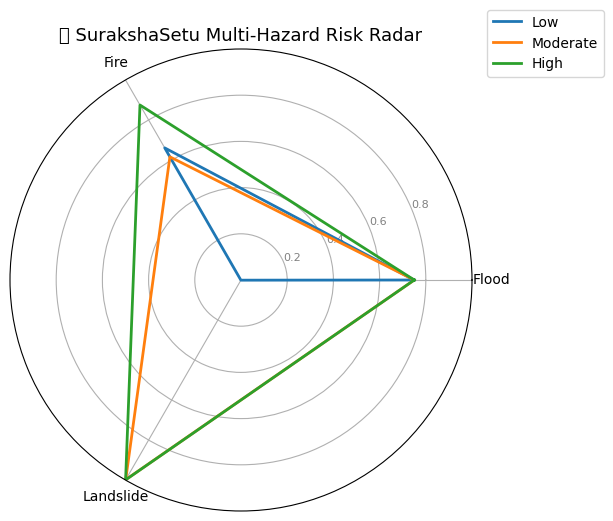

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_radar(df_results):
    labels = ['Flood', 'Fire', 'Landslide']
    num_vars = len(labels)
    angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6,6))
    for i, row in df_results.iterrows():
        values = [row['Flood_Score'], row['Fire'], row['Landslide']]
        values += values[:1]
        plt.polar(angles, values, label=row['Scenario'], linewidth=2)

    plt.xticks(angles[:-1], labels)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.1))
    plt.title("🌍 SurakshaSetu Multi-Hazard Risk Radar", size=13)
    plt.show()

plot_radar(df_results)
